In [1]:
# This project comprises three datasets obtained from Kaggle. The links are as follows:
# - International Football Results: https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017/discussion
# - FIFA World Ranking: https://www.kaggle.com/datasets/cashncarry/fifaworldranking
# The International Football Results dataset provides information such as home score, away score, date, location, and tournament for international soccer matches.
# A second table from the International Football Results dataset provides information about each goal scored, with columns like date, team, scorer, and minute.
# The FIFA World Ranking dataset includes information such as rank, rank date, country, total points, and confederation.
# The goal of the project is to create a model that can predict the results of the home team. The model will predict whether the home team won, lost, or tied.
# "Home_result" is the target variable, which was created through feature engineering.

In [2]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

In [3]:
results_df = pd.read_csv(r"C:\Users\leonc\OneDrive\Documents\Thinkful\Datasets\Soccer\results.csv")

In [4]:
results_df["date"] = pd.to_datetime(results_df["date"])

In [5]:
results_df = results_df[(results_df["date"] >= "2015-1-1")].reset_index(drop=True)

In [6]:
results_df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,2015-01-04,Bahrain,Jordan,1,0,Friendly,Ballarat,Australia,True
1,2015-01-04,Iran,Iraq,1,0,Friendly,Wollongong,Australia,True
2,2015-01-04,South Korea,Saudi Arabia,2,0,Friendly,Parramatta,Australia,True
3,2015-01-04,South Africa,Zambia,1,0,Friendly,Johannesburg,South Africa,False
4,2015-01-05,China PR,Oman,4,1,Friendly,Penrith,Australia,True


In [7]:
results_df['year'] = results_df['date'].dt.year
results_df['month'] = results_df['date'].dt.month
results_df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month
0,2015-01-04,Bahrain,Jordan,1,0,Friendly,Ballarat,Australia,True,2015,1
1,2015-01-04,Iran,Iraq,1,0,Friendly,Wollongong,Australia,True,2015,1
2,2015-01-04,South Korea,Saudi Arabia,2,0,Friendly,Parramatta,Australia,True,2015,1
3,2015-01-04,South Africa,Zambia,1,0,Friendly,Johannesburg,South Africa,False,2015,1
4,2015-01-05,China PR,Oman,4,1,Friendly,Penrith,Australia,True,2015,1


In [8]:
ranking_df= pd.read_csv(r"C:\Users\leonc\OneDrive\Documents\Thinkful\Datasets\Soccer\fifa_ranking.csv")

In [9]:
ranking_df['rank_date'] = pd.to_datetime(ranking_df['rank_date'])

In [10]:
ranking_df = ranking_df[(ranking_df["rank_date"] >= "2015-1-1")].reset_index(drop=True)

In [11]:
ranking_df.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,147,Malta,MLT,166.0,166.0,0,UEFA,2015-01-08
1,154,Malaysia,MAS,139.0,138.0,0,AFC,2015-01-08
2,153,New Caledonia,NCL,142.0,142.0,0,OFC,2015-01-08
3,152,Kyrgyz Republic,KGZ,146.0,146.0,0,AFC,2015-01-08
4,147,Madagascar,MAD,166.0,166.0,0,CAF,2015-01-08


In [12]:
ranking_df['year']= ranking_df['rank_date'].dt.year
ranking_df['month'] = ranking_df['rank_date'].dt.month
ranking_df.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date,year,month
0,147,Malta,MLT,166.0,166.0,0,UEFA,2015-01-08,2015,1
1,154,Malaysia,MAS,139.0,138.0,0,AFC,2015-01-08,2015,1
2,153,New Caledonia,NCL,142.0,142.0,0,OFC,2015-01-08,2015,1
3,152,Kyrgyz Republic,KGZ,146.0,146.0,0,AFC,2015-01-08,2015,1
4,147,Madagascar,MAD,166.0,166.0,0,CAF,2015-01-08,2015,1


In [13]:
ranking_df_subset = ranking_df[['rank_date', 'total_points','country_full']]
print(ranking_df_subset)

       rank_date  total_points       country_full
0     2015-01-08        166.00              Malta
1     2015-01-08        139.00           Malaysia
2     2015-01-08        142.00      New Caledonia
3     2015-01-08        146.00    Kyrgyz Republic
4     2015-01-08        166.00         Madagascar
...          ...           ...                ...
16820 2023-07-20       1354.65         Cabo Verde
16821 2023-07-20       1352.98            Iceland
16822 2023-07-20       1350.53    North Macedonia
16823 2023-07-20       1409.73            Jamaica
16824 2023-07-20        816.59  US Virgin Islands

[16825 rows x 3 columns]


In [14]:
ranking_df['rank_date'].unique()

array(['2015-01-08T00:00:00.000000000', '2015-02-12T00:00:00.000000000',
       '2015-03-12T00:00:00.000000000', '2015-04-09T00:00:00.000000000',
       '2015-05-07T00:00:00.000000000', '2015-06-04T00:00:00.000000000',
       '2015-07-09T00:00:00.000000000', '2015-08-06T00:00:00.000000000',
       '2015-09-03T00:00:00.000000000', '2015-10-01T00:00:00.000000000',
       '2015-11-05T00:00:00.000000000', '2015-12-03T00:00:00.000000000',
       '2016-01-07T00:00:00.000000000', '2016-02-04T00:00:00.000000000',
       '2016-03-03T00:00:00.000000000', '2016-04-07T00:00:00.000000000',
       '2016-05-05T00:00:00.000000000', '2016-06-02T00:00:00.000000000',
       '2016-07-14T00:00:00.000000000', '2016-08-11T00:00:00.000000000',
       '2016-09-15T00:00:00.000000000', '2016-10-20T00:00:00.000000000',
       '2016-11-24T00:00:00.000000000', '2016-12-22T00:00:00.000000000',
       '2017-01-12T00:00:00.000000000', '2017-02-09T00:00:00.000000000',
       '2017-03-09T00:00:00.000000000', '2017-04-06

In [15]:
ranking_df['total_points'].unique()

array([ 166.  ,  139.  ,  142.  , ..., 1395.57, 1368.25, 1409.73])

In [16]:
ranking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16825 entries, 0 to 16824
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   rank             16825 non-null  int64         
 1   country_full     16825 non-null  object        
 2   country_abrv     16825 non-null  object        
 3   total_points     16825 non-null  float64       
 4   previous_points  16825 non-null  float64       
 5   rank_change      16825 non-null  int64         
 6   confederation    16825 non-null  object        
 7   rank_date        16825 non-null  datetime64[ns]
 8   year             16825 non-null  int64         
 9   month            16825 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 1.3+ MB


In [17]:
ranking_df.value_counts('rank_date')

rank_date
2018-08-16    211
2022-08-25    211
2018-07-01    211
2019-07-25    211
2019-06-14    211
             ... 
2016-03-03    203
2016-02-04    203
2016-01-07    203
2015-12-03    203
2016-05-05    203
Length: 81, dtype: int64

In [18]:
ranking_df.value_counts('rank')

rank
29     96
184    96
173    96
159    94
118    94
       ..
207    43
208    42
209    37
210    37
211    15
Length: 211, dtype: int64

In [19]:
ranking_df.value_counts('country_full')

country_full
Afghanistan             81
Nicaragua               81
Mongolia                81
Montenegro              81
Montserrat              81
                        ..
Türkiye                  5
St Lucia                 5
Hong Kong, China         3
Aotearoa New Zealand     1
São Tomé e Príncipe      1
Length: 226, dtype: int64

In [20]:
print(ranking_df.isnull().sum().sum())

0


In [21]:
ranking_df.shape

(16825, 10)

In [22]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8268 entries, 0 to 8267
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        8268 non-null   datetime64[ns]
 1   home_team   8268 non-null   object        
 2   away_team   8268 non-null   object        
 3   home_score  8268 non-null   int64         
 4   away_score  8268 non-null   int64         
 5   tournament  8268 non-null   object        
 6   city        8268 non-null   object        
 7   country     8268 non-null   object        
 8   neutral     8268 non-null   bool          
 9   year        8268 non-null   int64         
 10  month       8268 non-null   int64         
dtypes: bool(1), datetime64[ns](1), int64(4), object(5)
memory usage: 654.1+ KB


In [23]:
results_df.shape

(8268, 11)

In [24]:
print(results_df.isnull().sum().sum())

0


In [25]:
results_df.value_counts('home_team')

home_team
United States    99
Mexico           92
Japan            80
Qatar            78
South Korea      75
                 ..
Raetia            1
Aymara            1
Vatican City      1
Ticino            1
Galicia           1
Length: 280, dtype: int64

In [26]:
results_df.value_counts('date')

date
2016-03-29    64
2023-11-21    56
2022-03-29    55
2023-10-17    52
2015-11-17    51
              ..
2019-01-02     1
2018-12-29     1
2018-12-23     1
2018-12-15     1
2019-03-04     1
Length: 1218, dtype: int64

In [27]:
results_df['date'].unique()

array(['2015-01-04T00:00:00.000000000', '2015-01-05T00:00:00.000000000',
       '2015-01-07T00:00:00.000000000', ...,
       '2023-11-19T00:00:00.000000000', '2023-11-20T00:00:00.000000000',
       '2023-11-21T00:00:00.000000000'], dtype='datetime64[ns]')

In [28]:
results_df.value_counts('neutral')

neutral
False    5869
True     2399
dtype: int64

In [29]:
mismatched_home_teams = results_df[~results_df['home_team'].isin(ranking_df['country_full'])]['home_team'].unique()
print(mismatched_home_teams)



['Iran' 'South Korea' 'Cape Verde' 'North Korea' 'Ivory Coast' 'DR Congo'
 'United States' 'Taiwan' 'Brunei' 'Saint Kitts and Nevis' 'French Guiana'
 'United States Virgin Islands' 'Saint Lucia' 'Corsica'
 'Saint Vincent and the Grenadines' 'Kyrgyzstan' 'Székely Land' 'Padania'
 'Romani people' 'Felvidék' 'County of Nice' 'Ellan Vannin' 'Greenland'
 'Saare County' 'Ynys Môn' 'Falkland Islands' 'Shetland' 'Western Isles'
 'Jersey' 'Isle of Man' 'Åland Islands' 'Menorca' 'Guernsey'
 'Isle of Wight' 'Hitra' 'Gotland' 'Alderney' 'Zanzibar' 'Martinique'
 'Catalonia' 'Guadeloupe' 'Sint Maarten' 'Galicia' 'Abkhazia'
 'Iraqi Kurdistan' 'Sápmi' 'Chagos Islands' 'United Koreans in Japan'
 'Raetia' 'Northern Cyprus' 'Somaliland' 'Western Armenia'
 'Northern Mariana Islands' 'Barawa' 'Basque Country' 'Vatican City'
 'Kárpátalja' 'South Ossetia' 'Orkney' 'Frøya' 'Tuvalu' 'Yorkshire'
 'Panjab' 'Tamil Eelam' 'Matabeleland' 'Tibet' 'Cascadia' 'Kabylia'
 'Bonaire' 'Saint Martin' 'Parishes of Jersey' 'K

In [30]:
replacement_dict_A = {'USA': 'United States', 'IR Iran': 'Iran', 'DR Congo':'Congo'}


ranking_df['country_full'] = ranking_df['country_full'].replace(replacement_dict_A)

In [31]:
replacement_dict_B = {'Central Spain': 'Spain','China PR':'China'}


results_df['home_team'] = results_df['home_team'].replace(replacement_dict_B)

In [32]:
def home_result(results_df):
    if results_df.home_score > results_df.away_score:
        return 'Win'
    if results_df.home_score < results_df.away_score:
        return 'Lost'
    else:
        return 'Tie'
    
results_df['home_result'] = results_df.apply(home_result,axis=1)
results_df.head(20)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,month,home_result
0,2015-01-04,Bahrain,Jordan,1,0,Friendly,Ballarat,Australia,True,2015,1,Win
1,2015-01-04,Iran,Iraq,1,0,Friendly,Wollongong,Australia,True,2015,1,Win
2,2015-01-04,South Korea,Saudi Arabia,2,0,Friendly,Parramatta,Australia,True,2015,1,Win
3,2015-01-04,South Africa,Zambia,1,0,Friendly,Johannesburg,South Africa,False,2015,1,Win
4,2015-01-05,China,Oman,4,1,Friendly,Penrith,Australia,True,2015,1,Win
5,2015-01-07,Cameroon,DR Congo,1,1,Friendly,Yaoundé,Cameroon,False,2015,1,Tie
6,2015-01-09,Australia,Kuwait,4,1,AFC Asian Cup,Melbourne,Australia,False,2015,1,Win
7,2015-01-09,Senegal,Gabon,1,0,Friendly,Casablanca,Morocco,True,2015,1,Win
8,2015-01-10,Burkina Faso,Eswatini,5,1,Friendly,Nelspruit,South Africa,True,2015,1,Win
9,2015-01-10,Cameroon,South Africa,1,1,Friendly,Libreville,Gabon,True,2015,1,Tie


In [33]:
df_first_merge = pd.merge(ranking_df, results_df,
               left_on=['country_full', 'year', 'month'],
               right_on=['home_team', 'year', 'month'])

In [34]:
df_first_merge = df_first_merge.drop(['previous_points', 'country_abrv', 'rank_change', 'confederation', 'tournament', 'city', 'country', 'neutral'], axis=1)

In [35]:
df_first_merge = df_first_merge.sort_values(by='rank')

In [36]:
df_first_merge.head()

,rank,country_full,total_points,rank_date,year,month,date,home_team,away_team,home_score,away_score,home_result
4265,1,Belgium,1765.0,2020-10-22,2020,10,2020-10-08,Belgium,Ivory Coast,1,1,Tie
3441,1,Belgium,1746.0,2019-06-14,2019,6,2019-06-08,Belgium,Kazakhstan,3,0,Win
233,1,Germany,1775.0,2015-06-04,2015,6,2015-06-10,Germany,United States,1,2,Lost
1261,1,Argentina,1503.0,2016-06-02,2016,6,2016-06-26,Argentina,Chile,0,0,Tie
1260,1,Argentina,1503.0,2016-06-02,2016,6,2016-06-18,Argentina,Venezuela,4,1,Win


In [37]:
X = df_first_merge[['rank', 'total_points']]
y = df_first_merge['home_result']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


hyperparameters = {'max_depth': 2,'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

#RandomForestClassifier with  hyperparameters
clf = RandomForestClassifier(**hyperparameters, random_state=0)



clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.49644760213143874
Classification Report:
               precision    recall  f1-score   support

        Lost       0.53      0.18      0.26       325
         Tie       0.00      0.00      0.00       263
         Win       0.49      0.93      0.65       538

    accuracy                           0.50      1126
   macro avg       0.34      0.37      0.30      1126
weighted avg       0.39      0.50      0.38      1126

Confusion Matrix:
 [[ 57   0 268]
 [ 15   0 248]
 [ 36   0 502]]


C:\Users\leonc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\leonc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\leonc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [38]:
scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores: {scores}')
print(f'Mean Accuracy: {scores.mean()}')

Cross-Validation Accuracy Scores: [0.47246892 0.47246892 0.47246892 0.47246892 0.47069272 0.46003552
 0.25754885 0.47330961 0.28825623 0.29359431]
Mean Accuracy: 0.41333128954571025


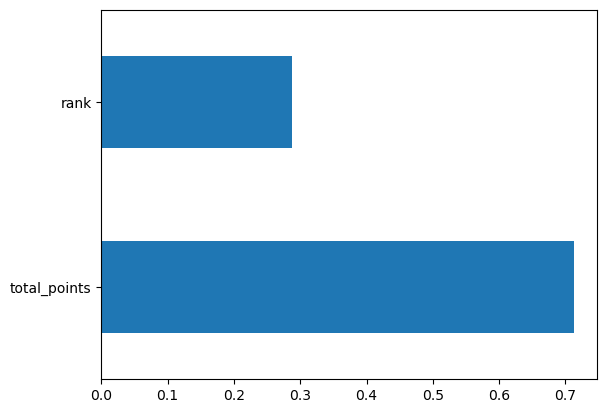

In [39]:
rfc = RandomForestClassifier(n_estimators=10, n_jobs=-1)
rfc.fit(X, y) 
feat_importances = pd.Series(rfc.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [40]:
data_points = df_first_merge[['rank', 'total_points']].values

# Make predictions on multiple data points
predictions = clf.predict(data_points)

# Add the 'home_team' column in front of the predictions
results = pd.DataFrame({'home_team': df_first_merge['home_team'], 'prediction': predictions, 'away_team': df_first_merge['away_team']})
results.head()

C:\Users\leonc\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,home_team,prediction,away_team
4265,Belgium,Win,Ivory Coast
3441,Belgium,Win,Kazakhstan
233,Germany,Win,United States
1261,Argentina,Win,Chile
1260,Argentina,Win,Venezuela


In [41]:
result_counts_by_country = df_first_merge.groupby('country_full')['home_result'].value_counts().unstack(fill_value=0)
result_counts_by_country.columns = ['Lost', 'Tie', 'Win']
result_counts_by_country['Total'] = result_counts_by_country.sum(axis=1)

print(result_counts_by_country)

                Lost  Tie  Win  Total
country_full                         
Afghanistan        4    4    9     17
Albania           16    6   16     38
Algeria            8    8   24     40
American Samoa     2    1    2      5
Andorra           18    8    7     33
...              ...  ...  ...    ...
Vietnam            5    9   17     31
Wales              7   11   17     35
Yemen             10    4    5     19
Zambia            10   16   15     41
Zimbabwe           6    8   14     28

[198 rows x 4 columns]


In [42]:
result_counts_by_country['Win_Percentage'] = (result_counts_by_country['Win'] / result_counts_by_country['Total']) * 100

df_first_merge['Win_Percentage'] = df_first_merge['country_full'].map(result_counts_by_country['Win_Percentage'])


In [43]:
result_counts_by_country['Tie_Percentage'] = (result_counts_by_country['Tie'] / result_counts_by_country['Total']) * 100

df_first_merge['Tie_Percentage'] = df_first_merge['country_full'].map(result_counts_by_country['Tie_Percentage'])


In [44]:
result_counts_by_country['Lost_Percentage'] = (result_counts_by_country['Lost'] / result_counts_by_country['Total']) * 100

df_first_merge['Lost_Percentage'] = df_first_merge['country_full'].map(result_counts_by_country['Lost_Percentage'])

df_first_merge.head()

,rank,country_full,total_points,rank_date,year,month,date,home_team,away_team,home_score,away_score,home_result,Win_Percentage,Tie_Percentage,Lost_Percentage
4265,1,Belgium,1765.0,2020-10-22,2020,10,2020-10-08,Belgium,Ivory Coast,1,1,Tie,75.000000,15.909091,9.090909
3441,1,Belgium,1746.0,2019-06-14,2019,6,2019-06-08,Belgium,Kazakhstan,3,0,Win,75.000000,15.909091,9.090909
233,1,Germany,1775.0,2015-06-04,2015,6,2015-06-10,Germany,United States,1,2,Lost,58.000000,28.000000,14.000000
1261,1,Argentina,1503.0,2016-06-02,2016,6,2016-06-26,Argentina,Chile,0,0,Tie,64.150943,24.528302,11.320755
1260,1,Argentina,1503.0,2016-06-02,2016,6,2016-06-18,Argentina,Venezuela,4,1,Win,64.150943,24.528302,11.320755


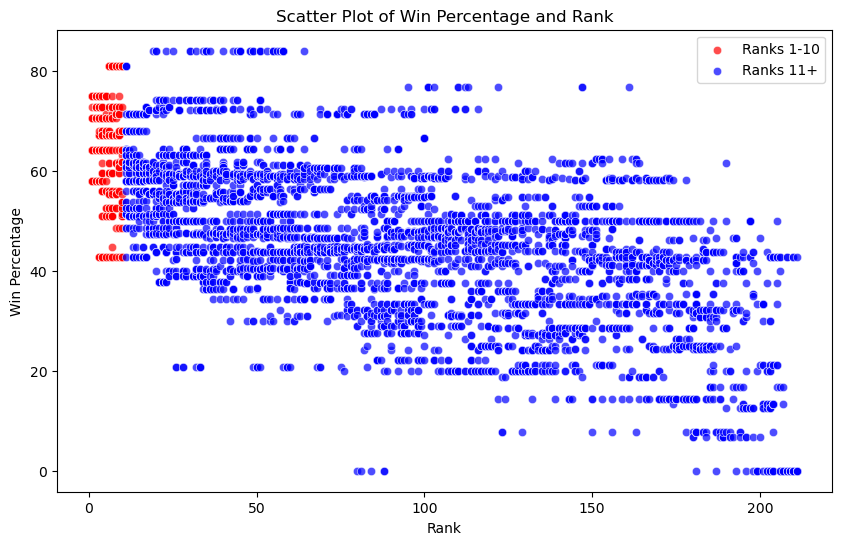

In [45]:
df = df_first_merge.copy()

# Scatter plot for Win_Percentage and rank
plt.figure(figsize=(10, 6))

# Scatter plot for ranks 1-10 in red
sns.scatterplot(x='rank', y='Win_Percentage', data=df[df['rank'].between(1, 10)], color='red', alpha=0.7, label='Ranks 1-10')

# Scatter plot for ranks other than 1-10 in blue
sns.scatterplot(x='rank', y='Win_Percentage', data=df[~df['rank'].between(1, 10)], color='blue', alpha=0.7, label='Ranks 11+')

plt.title('Scatter Plot of Win Percentage and Rank')
plt.xlabel('Rank')
plt.ylabel('Win Percentage')
plt.legend()
plt.show()

In [47]:
goalscorers_df= pd.read_csv(r"C:\Users\leonc\OneDrive\Documents\Thinkful\Datasets\Soccer\goalscorers.csv")

In [48]:
goalscorers_df.shape

(43189, 8)

In [49]:
goalscorers_df.head()

,date,home_team,away_team,team,scorer,minute,own_goal,penalty
0,1916-07-02,Chile,Uruguay,Uruguay,José Piendibene,44.0,False,False
1,1916-07-02,Chile,Uruguay,Uruguay,Isabelino Gradín,55.0,False,False
2,1916-07-02,Chile,Uruguay,Uruguay,Isabelino Gradín,70.0,False,False
3,1916-07-02,Chile,Uruguay,Uruguay,José Piendibene,75.0,False,False
4,1916-07-06,Argentina,Chile,Argentina,Alberto Ohaco,2.0,False,False


In [50]:
goalscorers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43189 entries, 0 to 43188
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       43189 non-null  object 
 1   home_team  43189 non-null  object 
 2   away_team  43189 non-null  object 
 3   team       43189 non-null  object 
 4   scorer     43139 non-null  object 
 5   minute     42929 non-null  float64
 6   own_goal   43187 non-null  object 
 7   penalty    43187 non-null  object 
dtypes: float64(1), object(7)
memory usage: 2.6+ MB


In [51]:
goalscorers_df.value_counts('team')

team
Brazil           1046
Germany           958
Argentina         914
Spain             875
Netherlands       832
                 ... 
Yemen DPR           4
Somalia             3
French Guiana       2
Anguilla            2
South Sudan         2
Length: 220, dtype: int64

In [52]:
goalscorers_df = goalscorers_df.dropna()
goalscorers_df = goalscorers_df.drop(['home_team', 'away_team'], axis=1)

In [53]:
goalscorers_df["date"] = pd.to_datetime(goalscorers_df["date"])

goalscorers_df = goalscorers_df[(goalscorers_df["date"] >= "2015-1-1")].reset_index(drop=True)

goalscorers_df['year'] = goalscorers_df['date'].dt.year
goalscorers_df['month'] = goalscorers_df['date'].dt.month
goalscorers_df.head()


,date,team,scorer,minute,own_goal,penalty,year,month
0,2015-01-09,Kuwait,Hussain Fadhel,8.0,False,False,2015,1
1,2015-01-09,Australia,Tim Cahill,33.0,False,False,2015,1
2,2015-01-09,Australia,Massimo Luongo,45.0,False,False,2015,1
3,2015-01-09,Australia,Mile Jedinak,62.0,False,True,2015,1
4,2015-01-09,Australia,James Troisi,90.0,False,False,2015,1


In [54]:
goalscorers_df['scorer_goal_count'] = goalscorers_df.groupby('scorer')['scorer'].transform('count')
goalscorers_df.head()

,date,team,scorer,minute,own_goal,penalty,year,month,scorer_goal_count
0,2015-01-09,Kuwait,Hussain Fadhel,8.0,False,False,2015,1,1
1,2015-01-09,Australia,Tim Cahill,33.0,False,False,2015,1,14
2,2015-01-09,Australia,Massimo Luongo,45.0,False,False,2015,1,5
3,2015-01-09,Australia,Mile Jedinak,62.0,False,True,2015,1,13
4,2015-01-09,Australia,James Troisi,90.0,False,False,2015,1,3


In [55]:
df_second_merge = pd.merge(df_first_merge, goalscorers_df,
               left_on=[ 'home_team','year', 'month'],
               right_on=[ 'team','year', 'month'])

In [56]:
# Create a new column 'total_goal_difference' based on 'home_result'
df_second_merge['goal_difference'] = 0

# 'total_goal_difference' for 'Win' 
df_second_merge.loc[df_second_merge['home_result'] == 'Win', 'goal_difference'] = df_second_merge['home_score'] - df_second_merge['away_score']

# 'total_goal_difference' for 'Lost' 
df_second_merge.loc[df_second_merge['home_result'] == 'Lost', 'goal_difference'] = df_second_merge['home_score'] - df_second_merge['away_score']

# Group by 'country_full' and sum 'total_goal_difference'
total_goal_difference_by_country = df_second_merge.groupby('country_full')['goal_difference'].sum().reset_index()

# Merge the total_goal_difference back to the original DataFrame
df_second_merge = pd.merge(df_second_merge, total_goal_difference_by_country, on='country_full', how='left', suffixes=('', '_total'))

In [57]:
df_second_merge.shape

(10198, 24)

In [58]:
pd.set_option('display.max_columns', None)
df_second_merge.head(100)

,rank,country_full,total_points,rank_date,year,month,date_x,home_team,away_team,home_score,away_score,home_result,Win_Percentage,Tie_Percentage,Lost_Percentage,date_y,team,scorer,minute,own_goal,penalty,scorer_goal_count,goal_difference,goal_difference_total
0,1,Belgium,1765.0,2020-10-22,2020,10,2020-10-08,Belgium,Ivory Coast,1,1,Tie,75.000000,15.909091,9.090909,2020-10-11,Belgium,Romelu Lukaku,16.0,False,True,58,0,702
1,1,Belgium,1765.0,2020-10-22,2020,10,2020-10-08,Belgium,Ivory Coast,1,1,Tie,75.000000,15.909091,9.090909,2020-10-14,Belgium,Romelu Lukaku,9.0,False,False,58,0,702
2,1,Belgium,1765.0,2020-10-22,2020,10,2020-10-08,Belgium,Ivory Coast,1,1,Tie,75.000000,15.909091,9.090909,2020-10-14,Belgium,Romelu Lukaku,38.0,False,True,58,0,702
3,1,Belgium,1746.0,2019-06-14,2019,6,2019-06-08,Belgium,Kazakhstan,3,0,Win,75.000000,15.909091,9.090909,2019-06-08,Belgium,Dries Mertens,11.0,False,False,12,3,702
4,1,Belgium,1746.0,2019-06-14,2019,6,2019-06-08,Belgium,Kazakhstan,3,0,Win,75.000000,15.909091,9.090909,2019-06-08,Belgium,Timothy Castagne,14.0,False,False,2,3,702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,Argentina,1503.0,2016-06-02,2016,6,2016-06-06,Argentina,Chile,2,1,Win,64.150943,24.528302,11.320755,2016-06-06,Argentina,Éver Banega,59.0,False,False,1,1,454
96,1,Argentina,1503.0,2016-06-02,2016,6,2016-06-06,Argentina,Chile,2,1,Win,64.150943,24.528302,11.320755,2016-06-10,Argentina,Nicolás Otamendi,7.0,False,False,2,1,454
97,1,Argentina,1503.0,2016-06-02,2016,6,2016-06-06,Argentina,Chile,2,1,Win,64.150943,24.528302,11.320755,2016-06-10,Argentina,Lionel Messi,68.0,False,False,33,1,454
98,1,Argentina,1503.0,2016-06-02,2016,6,2016-06-06,Argentina,Chile,2,1,Win,64.150943,24.528302,11.320755,2016-06-10,Argentina,Lionel Messi,78.0,False,False,33,1,454


In [59]:
print(df_second_merge.columns)

Index(['rank', 'country_full', 'total_points', 'rank_date', 'year', 'month',
       'date_x', 'home_team', 'away_team', 'home_score', 'away_score',
       'home_result', 'Win_Percentage', 'Tie_Percentage', 'Lost_Percentage',
       'date_y', 'team', 'scorer', 'minute', 'own_goal', 'penalty',
       'scorer_goal_count', 'goal_difference', 'goal_difference_total'],
      dtype='object')


C:\Users\leonc\AppData\Local\Temp\ipykernel_7304\2491785080.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='goal_difference_total_bins', y='Win_Percentage', data=df_second_merge, ci=None)


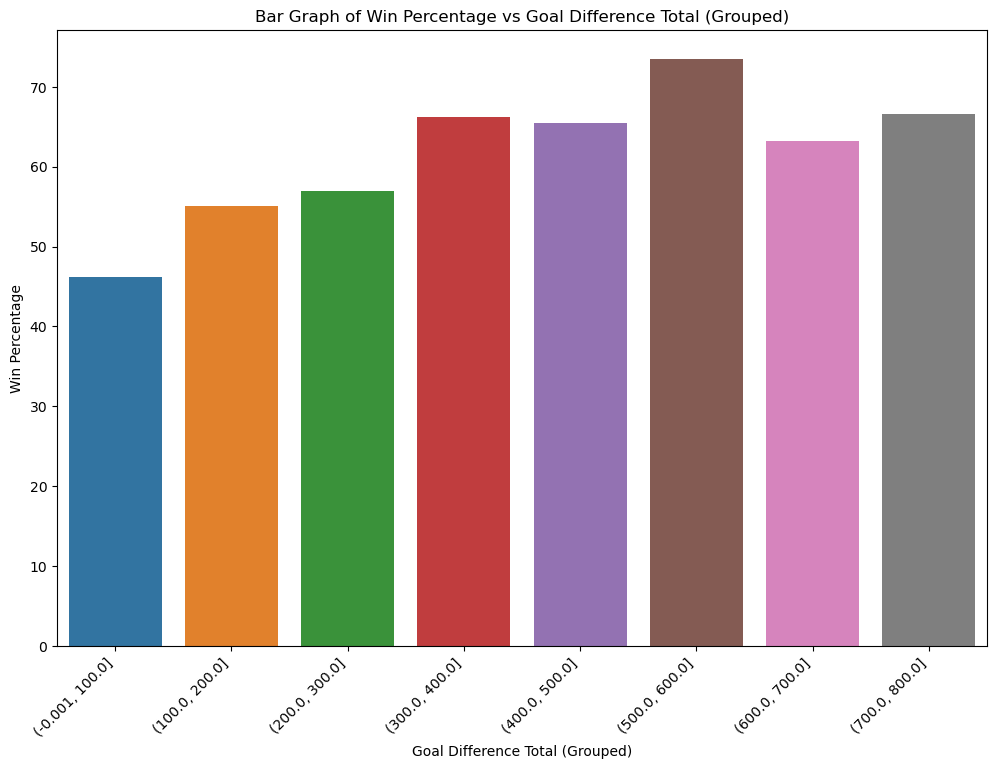

In [60]:
bins_goal_difference = range(0, int(df_second_merge['goal_difference_total'].max()) + 101, 100)

# Create a new column 'goal_difference_total_bins' based on the bins
df_second_merge['goal_difference_total_bins'] = pd.cut(df_second_merge['goal_difference_total'], bins=bins_goal_difference, include_lowest=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='goal_difference_total_bins', y='Win_Percentage', data=df_second_merge, ci=None)
plt.title('Bar Graph of Win Percentage vs Goal Difference Total (Grouped)')
plt.xlabel('Goal Difference Total (Grouped)')
plt.ylabel('Win Percentage')
plt.xticks(rotation=45, ha='right')  
plt.show()

C:\Users\leonc\AppData\Local\Temp\ipykernel_7304\3619789604.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='goal_difference_total_bins', y='Lost_Percentage', data=df_second_merge, ci=None)


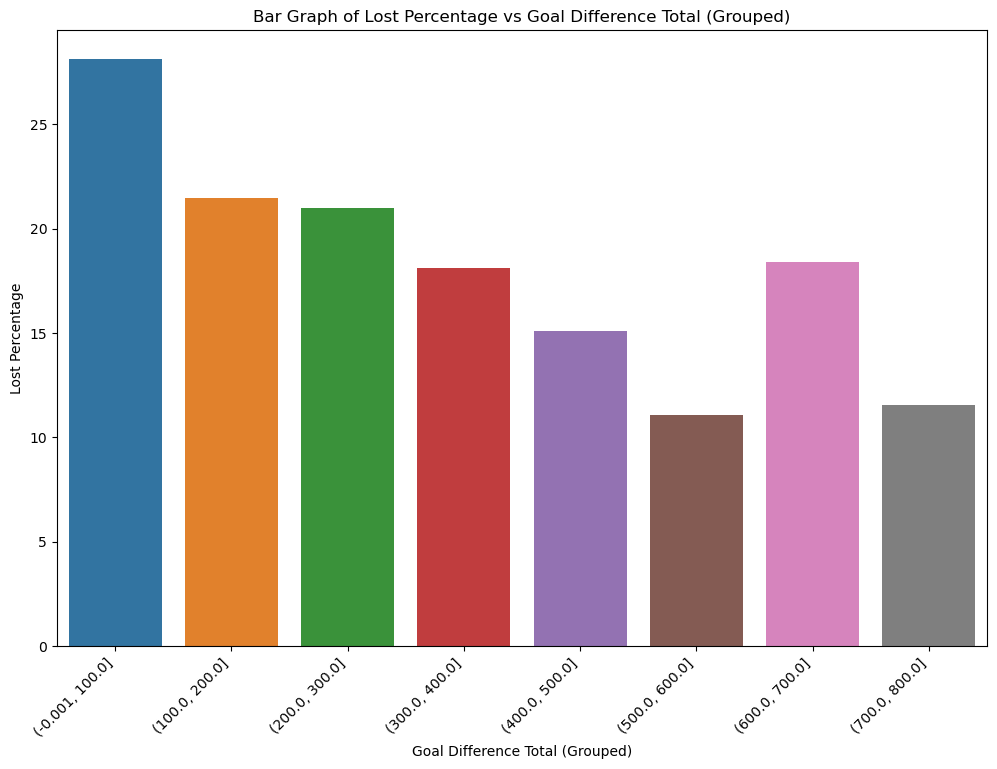

In [61]:
bins_goal_difference = range(0, int(df_second_merge['goal_difference_total'].max()) + 101, 100)

# Create a new column 'goal_difference_total_bins' based on the bins
df_second_merge['goal_difference_total_bins'] = pd.cut(df_second_merge['goal_difference_total'], bins=bins_goal_difference, include_lowest=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='goal_difference_total_bins', y='Lost_Percentage', data=df_second_merge, ci=None)
plt.title('Bar Graph of Lost Percentage vs Goal Difference Total (Grouped)')
plt.xlabel('Goal Difference Total (Grouped)')
plt.ylabel('Lost Percentage')
plt.xticks(rotation=45, ha='right')  
plt.show()

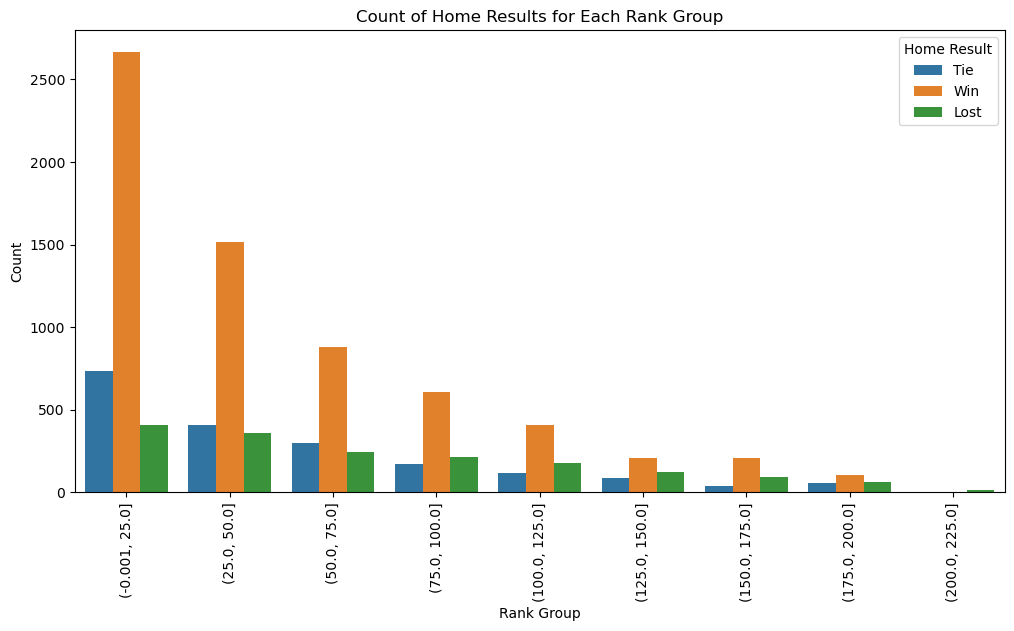

In [62]:
bin_edges = list(range(0, df_second_merge['rank'].max() + 26, 25))

# Create a new column 'rank_group' based on the bins
df_second_merge['rank_group'] = pd.cut(df_second_merge['rank'], bins=bin_edges, include_lowest=True)

plt.figure(figsize=(12, 6))
sns.countplot(x='rank_group', data=df_second_merge, hue='home_result')
plt.title('Count of Home Results for Each Rank Group')
plt.xlabel('Rank Group')
plt.ylabel('Count')
plt.xticks(rotation=90)  
plt.legend(title='Home Result')
plt.show()

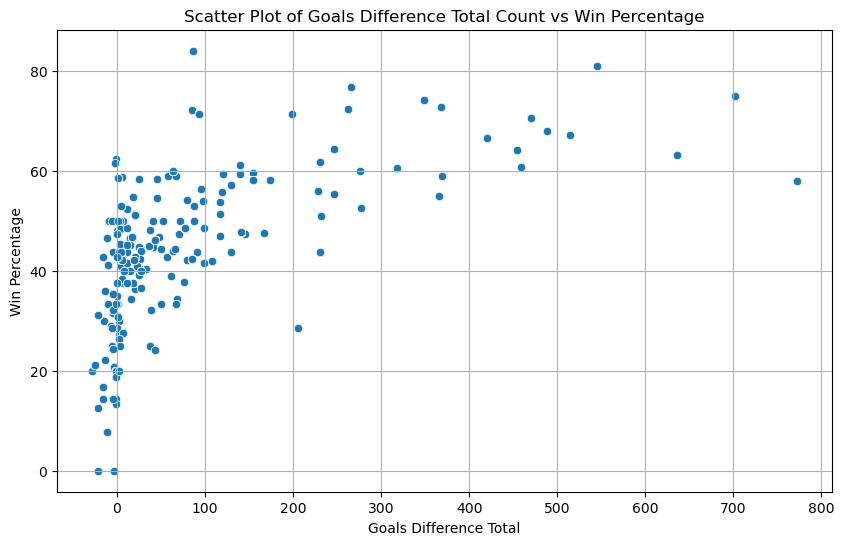

In [63]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='goal_difference_total', y='Win_Percentage', data=df_second_merge)
plt.title('Scatter Plot of Goals Difference Total Count vs Win Percentage')
plt.xlabel('Goals Difference Total')
plt.ylabel('Win Percentage')
plt.grid(True)
plt.show()

In [64]:
#  X and y are your feature matrix and target variable
X = df_second_merge[['rank', 'Win_Percentage','goal_difference_total']]

y = df_second_merge['home_result']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Instantiate the multinomial logistic regression model
multinomial_logreg_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=15000)

# Fit the model on the training data
multinomial_logreg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = multinomial_logreg_model.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.6352941176470588
Classification Report:
               precision    recall  f1-score   support

        Lost       0.54      0.07      0.12       383
         Tie       0.50      0.00      0.01       376
         Win       0.64      0.99      0.78      1281

    accuracy                           0.64      2040
   macro avg       0.56      0.35      0.30      2040
weighted avg       0.59      0.64      0.51      2040

Confusion Matrix:
 [[  25    1  357]
 [  10    1  365]
 [  11    0 1270]]


In [65]:
X = df_second_merge[['rank', 'Win_Percentage', 'goal_difference_total']]
Y = df_second_merge['home_result']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# Instantiate the Gradient Boosting Classifier model with the best hyperparameters
gb_classifier = GradientBoostingClassifier(learning_rate=0.2, max_depth=7, n_estimators=150)

# Fit the model on the training data
gb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gb_classifier.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:\n', classification_rep)
print('Confusion Matrix:\n', conf_matrix)

Accuracy: 0.6941176470588235
Classification Report:
               precision    recall  f1-score   support

        Lost       0.55      0.37      0.44       344
         Tie       0.50      0.38      0.43       386
         Win       0.75      0.87      0.81      1310

    accuracy                           0.69      2040
   macro avg       0.60      0.54      0.56      2040
weighted avg       0.67      0.69      0.68      2040

Confusion Matrix:
 [[ 128   50  166]
 [  33  146  207]
 [  73   95 1142]]


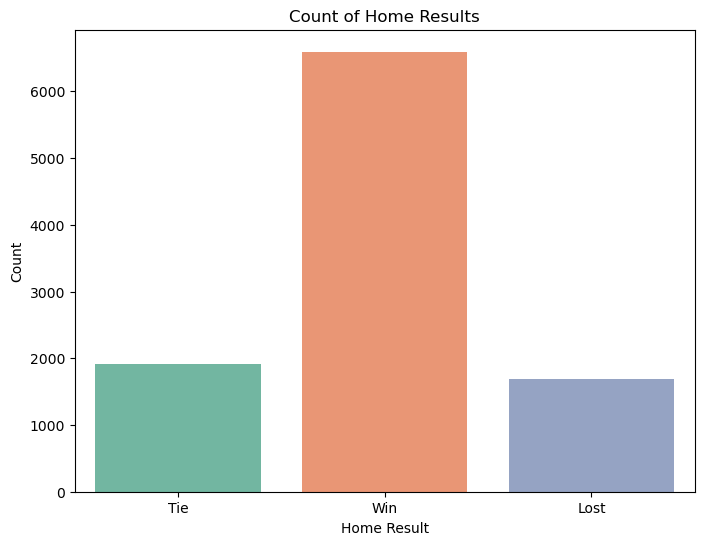

In [66]:
plt.figure(figsize=(8, 6))
sns.countplot(x='home_result', data=df_second_merge, palette='Set2')
plt.title('Count of Home Results')
plt.xlabel('Home Result')
plt.ylabel('Count')
plt.show()

In [67]:
# Encode target classes
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

X = df_second_merge[['rank', 'Win_Percentage', 'goal_difference_total']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y_encoded, test_size=0.2, random_state=1)

# Define the LightGBM classifier model with hyperparameters
lgbm_classifier = LGBMClassifier(learning_rate=0.2, max_depth=7, n_estimators=150, class_weight='balanced')

# Fit the model on the training data
lgbm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lgbm_classifier.predict(X_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:\n', classification_rep)
print('Confusion Matrix:\n', conf_matrix)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 415
[LightGBM] [Info] Number of data points in the train set: 8158, number of used features: 3
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [68]:
#The gradient boosting classifier has higher accuracy and performs better in terms of precision, recall
#and F1-score. 
#Based on accuracy and overall performance, the gradient boosting classifier 
#is the better-performing model when compared to the logistic regression and random forest models.
#The RandomForestClassifier is the worst model due to lower scores across all evaluation metrics. 
#Due to class imbalance, a final model was made to compete with the gradient boosting classifier. 
#LightGBM perform better with win precision, lost and tie recall, and f1-score.
#On the other hand, gradient boosting does better in lost and tie precision, win recall, f1-score, and accuracy.
#If precision for predicting win or recall for lost and tie is important, LightGBM can be used. 
#Gradient boosting can be used if overall acuracy, lost and tie precision, and win recall are crucial. 